In [169]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import requests
import tqdm
from tqdm import tqdm_notebook


import matplotlib.pyplot as plt
from PIL import Image


from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


import nltk
from nltk import tokenize
from transformers import BertModel, BertTokenizer


books=pd.read_csv('books_1.0.csv')
users=pd.read_csv('users_f_location_1.1.csv')
ratings=pd.read_csv('train_ratings.csv')

 


books_text_df = books[['isbn', 'summary']].copy()
books_text_df['summary'].fillna('None', inplace=True)
books_text_df.shape
books_text_df.head()

,isbn,summary
0,0002005018,"In a small town in Canada, Clara Callan reluct..."
1,0060973129,"Here, for the first time in paperback, is an o..."
2,0374157065,"Describes the great flu epidemic of 1918, an o..."
3,0399135782,A Chinese immigrant who is convinced she is dy...
4,0425176428,"Essays by respected military historians, inclu..."


In [170]:
# 기본적인 전처리
# 필요에 따라 전처리 함수 추가 가능
def text_preprocessing(summary):
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary

In [171]:
print("[before]")
print(books_text_df['summary'][0])
print("[after]")
print(text_preprocessing(books_text_df['summary'][0]))

# 적용
books_text_df['summary'] = books_text_df['summary'].apply(lambda x:text_preprocessing(x))
books_text_df['summary'].replace({'':'None', ' ':'None'}, inplace=True)

[before]
In a small town in Canada, Clara Callan reluctantly takes leave of her
sister, Nora, who is bound for New York.
[after]
in a small town in canada clara callan reluctantly takes leave of her sister nora who is bound for new york


In [172]:
df = ratings.copy()
df_fe = pd.merge(df, books_text_df[['isbn', 'summary']], how='inner', on='isbn')
df_fe['summary_length'] = df_fe['summary'].apply(lambda x:len(x))
print(df_fe.shape)
df_fe.head()

(306795, 5)


,user_id,isbn,rating,summary,summary_length
0,8,0002005018,4,in a small town in canada clara callan relucta...,107
1,67544,0002005018,7,in a small town in canada clara callan relucta...,107
2,123629,0002005018,8,in a small town in canada clara callan relucta...,107
3,200273,0002005018,8,in a small town in canada clara callan relucta...,107
4,210926,0002005018,9,in a small town in canada clara callan relucta...,107


In [173]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [174]:
# 유저 별 하나의 요약 문서 만들기
def summary_merge(df, user_id, max_summary):
    return " ".join(df[df['user_id'] == user_id].sort_values(by='summary_length', ascending=False)['summary'].values[:max_summary])

# 텍스트 벡터화
def text_to_vector(text, device):
    for sent in tokenize.sent_tokenize(text):
        text_ = "[CLS] " + sent + " [SEP]"
        tokenized = tokenizer.tokenize(text_)
        indexed = tokenizer.convert_tokens_to_ids(tokenized)
        segments_idx = [1] * len(tokenized)
        token_tensor = torch.tensor([indexed])
        sgments_tensor = torch.tensor([segments_idx])
        with torch.no_grad():
            outputs = model(token_tensor.to(device), sgments_tensor.to(device))
            encode_layers = outputs[0]
            sentence_embedding = torch.mean(encode_layers[0], dim=0)
    return sentence_embedding.cpu().detach().numpy()

In [7]:
user_summary_merge_vector = list(map(lambda x:text_to_vector(summary_merge(df_fe, x, 5), device), df_fe['user_id'].unique()))
user_review_text_df = pd.DataFrame(df_fe['user_id'].unique(), columns=['user_id'])
user_review_text_df['user_summary_merge_vector'] = user_summary_merge_vector
user_review_text_df.head()

,user_id,user_summary_merge_vector
0,8,"[-0.10631599, 0.07719624, 0.3148368, -0.046547..."
1,67544,"[-0.26861295, -0.05863912, 0.47870007, 0.00170..."
2,123629,"[-0.21812886, -0.20392, 0.064398155, -0.135915..."
3,200273,"[-0.21812886, -0.20392, 0.064398155, -0.135915..."
4,210926,"[-0.38687736, 0.074735105, 0.17002048, -0.2698..."


In [175]:
item_summary_vector = list(map(lambda x:text_to_vector(x, device), books_text_df['summary'].tolist()))

In [178]:
books_text_df['item_summary_vector'] = item_summary_vector

# User Review Text Vector 결합
df_fe_join = pd.merge(df_fe, user_review_text_df, on='user_id', how='left')
#  Item Review Text Vector 결합
df_fe_join = pd.merge(df_fe_join, books_text_df[['isbn', 'item_summary_vector']], on='isbn', how='left')
# encoding
user2idx = {v:k for k,v in enumerate(df_fe['user_id'].unique())}
book2idx = {v:k for k,v in enumerate(df_fe['isbn'].unique())}
print('unique user_id :', len(user2idx))
print('unique isbn :', len(book2idx))
df_fe_join['isbn'] = df_fe_join['isbn'].map(book2idx)
df_fe_join['user_id'] = df_fe_join['user_id'].map(user2idx)

print(df_fe_join.shape)
df_fe_join.head()

unique user_id : 59803
unique isbn : 129777
(306795, 7)


,user_id,isbn,rating,summary,summary_length,user_summary_merge_vector,item_summary_vector
0,0,0,4,in a small town in canada clara callan relucta...,107,"[-0.10631599, 0.07719624, 0.3148368, -0.046547...","[-0.21812886, -0.20392, 0.064398155, -0.135915..."
1,1,0,7,in a small town in canada clara callan relucta...,107,"[-0.26861295, -0.05863912, 0.47870007, 0.00170...","[-0.21812886, -0.20392, 0.064398155, -0.135915..."
2,2,0,8,in a small town in canada clara callan relucta...,107,"[-0.21812886, -0.20392, 0.064398155, -0.135915...","[-0.21812886, -0.20392, 0.064398155, -0.135915..."
3,3,0,8,in a small town in canada clara callan relucta...,107,"[-0.21812886, -0.20392, 0.064398155, -0.135915...","[-0.21812886, -0.20392, 0.064398155, -0.135915..."
4,4,0,9,in a small town in canada clara callan relucta...,107,"[-0.38687736, 0.074735105, 0.17002048, -0.2698...","[-0.21812886, -0.20392, 0.064398155, -0.135915..."


In [179]:
size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
                                                    df_fe_join[['user_id', 'isbn', 'user_summary_merge_vector', 'item_summary_vector']], 
                                                    df_fe_join['rating'], 
                                                    test_size=size, 
                                                    random_state=seed,
                                                    )
print(df_fe.shape)
print(X_train.shape)
print(X_test.shape)

(306795, 5)
(245436, 4)
(61359, 4)


In [203]:
class CNN(nn.Module):
    def __init__(self, word_dim, out_dim, kernel_size, conv_1d_out_dim):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
                                nn.Conv1d(
                                        in_channels=word_dim,
                                        out_channels=out_dim,
                                        kernel_size=kernel_size,
                                        padding=(kernel_size - 1) // 2), 
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(kernel_size, 1)),  
                                nn.Dropout(p=0.5)
                                )
        self.linear = nn.Sequential(
                                    nn.Linear(int(out_dim/kernel_size), conv_1d_out_dim),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5))

    def forward(self, vec): 
        output = self.conv(vec)  
        output = self.linear(output.reshape(-1, output.size(1)))
        return output 

class FactorizationMachine(nn.Module):
    def __init__(self, input_dim, latent_dim):  
        super().__init__()
        self.v = nn.Parameter(torch.rand(input_dim, latent_dim), requires_grad = True)
        self.linear = nn.Linear(input_dim, 1, bias=True)
    def forward(self, x):
        linear = self.linear(x)  
        square_of_sum = torch.mm(x, self.v) ** 2
        sum_of_square = torch.mm(x ** 2, self.v ** 2)
        pair_interactions = torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True)
        output = linear + (0.5 * pair_interactions)
        return output  

class DeepCoNN(nn.Module):
    def __init__(self, word_dim, out_dim, kernel_size, conv_1d_out_dim, latent_dim):
        super(DeepCoNN, self).__init__()
        self.cnn_u = CNN(
                         word_dim=word_dim, 
                         out_dim=out_dim, 
                         kernel_size=kernel_size, 
                         conv_1d_out_dim=conv_1d_out_dim,
                        )
        self.cnn_i = CNN(
                         word_dim=word_dim, 
                         out_dim=out_dim, 
                         kernel_size=kernel_size, 
                         conv_1d_out_dim=conv_1d_out_dim,
                        )
        self.fm = FactorizationMachine(
                                       input_dim=conv_1d_out_dim * 2, 
                                       latent_dim=latent_dim,
                                       )
    def forward(self, x):
        user_text_vector, item_text_vector = x[0], x[1]
        user_text_feature = self.cnn_u(user_text_vector)
        item_text_feature = self.cnn_i(item_text_vector)
        feature_vector = torch.cat([user_text_feature, item_text_feature], dim=1)
        output = self.fm(feature_vector)
        return output.squeeze(1)

class Dataset(Dataset):
    def __init__(self, user_summary_merge_vector, item_summary_vector, label):
        self.user_summary_merge_vector = user_summary_merge_vector
        self.item_summary_vector = item_summary_vector
        self.label = label
        
    def __len__(self):
        return self.user_summary_merge_vector.shape[0]
    
    def __getitem__(self, i):
        return {
                'user_summary_merge_vector' : torch.tensor(self.user_summary_merge_vector[i].reshape(-1, 1), dtype=torch.float32),
                'item_summary_vector' : torch.tensor(self.user_summary_merge_vector[i].reshape(-1, 1), dtype=torch.float32),
                'label' : torch.tensor(self.label[i], dtype=torch.float32),
                }
                
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.eps = 1e-6

    def forward(self, x, y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y)+self.eps)
        return loss

def rmse_score(actual, inference):
    return np.sqrt(sum((actual-inference)**2)/len(actual))

def train(model, optimizer, data_loader, criterion, device, epochs, model_name):
    minimum_loss = 999999999
    model.train()
    loss_list = []
    tk0 = tqdm.tqdm(range(epochs), smoothing=0, mininterval=1.0)
    for epoch in tk0:
        total_loss = 0
        n = 0
        for i, data in enumerate(data_loader):
            if len(data)==3:
                fields, target = [data['user_summary_merge_vector'].to(device), data['item_summary_vector'].to(device)], data['label'].to(device)
            elif len(data)==4:
                fields, target = [data['user_isbn_vector'].to(device), data['user_summary_merge_vector'].to(device), data['item_summary_vector'].to(device)], data['label'].to(device)
            
            y = model(fields)
            loss = criterion(y, target.float())
            model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            n += 1
        if minimum_loss > (total_loss/n):
            minimum_loss = (total_loss/n)
            torch.save(model.state_dict(), './{}.pt'.format(model_name))
            loss_list.append([epoch, total_loss/n, 'Model saved'])
        else:
            loss_list.append([epoch, total_loss/n, 'None'])
        tk0.set_postfix(loss=total_loss/n)
    loss_df = pd.DataFrame(loss_list, columns=['epoch', 'loss', 'check'])
    plt.figure(figsize=(21, 5))
    plt.title("Epoch vs Loss Plot")
    plt.plot(loss_df['epoch'], loss_df['loss'], label='loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 10)
    plt.legend()
    plt.show()

def test(model, data_loader, device, model_name):
    model.eval()
    model.load_state_dict(torch.load('./{}.pt'.format(model_name)))
    targets, predicts = list(), list()
    with torch.no_grad():
        for data in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            if len(data)==3:
                fields, target = [data['user_summary_merge_vector'].to(device), data['item_summary_vector'].to(device)], data['label'].to(device)
            elif len(data)==4:
                fields, target = [data['user_isbn_vector'].to(device), data['user_summary_merge_vector'].to(device), data['item_summary_vector'].to(device)], data['label'].to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return targets, predicts
    

In [204]:
class CNN(nn.Module):
    def __init__(self, word_dim, out_dim, kernel_size, conv_1d_out_dim):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
                                nn.Conv1d(
                                        in_channels=word_dim,
                                        out_channels=out_dim,
                                        kernel_size=kernel_size,
                                        padding=(kernel_size - 1) // 2), 
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=(kernel_size, 1)),  
                                nn.Dropout(p=0.5)
                                )
        self.linear = nn.Sequential(
                                    nn.Linear(int(out_dim/kernel_size), conv_1d_out_dim),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5))

    def forward(self, vec): 
        output = self.conv(vec)  
        output = self.linear(output.reshape(-1, output.size(1)))
        return output 

class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        x = self.embedding(x)
        return x.view(-1, x.size(1) * x.size(2))

class DeepCoNN(nn.Module):
    def __init__(self, field_dims, embed_dim, word_dim, out_dim, kernel_size, conv_1d_out_dim, latent_dim):
        super(DeepCoNN, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.cnn_u = CNN(
                         word_dim=word_dim, 
                         out_dim=out_dim, 
                         kernel_size=kernel_size, 
                         conv_1d_out_dim=conv_1d_out_dim,
                        )
        self.cnn_i = CNN(
                         word_dim=word_dim, 
                         out_dim=out_dim, 
                         kernel_size=kernel_size, 
                         conv_1d_out_dim=conv_1d_out_dim,
                        )
        self.fm = FactorizationMachine(
                                       input_dim=(conv_1d_out_dim * 2) + (embed_dim*len(field_dims)), 
                                       latent_dim=latent_dim,
                                       )
    def forward(self, x):
        user_isbn_vector, user_text_vector, item_text_vector = x[0], x[1], x[2]
        user_isbn_feature = self.embedding(user_isbn_vector)                    
        user_text_feature = self.cnn_u(user_text_vector)
        item_text_feature = self.cnn_i(item_text_vector)
        feature_vector = torch.cat([user_isbn_feature, user_text_feature, item_text_feature], dim=1)
        output = self.fm(feature_vector)
        return output.squeeze(1)

class Dataset(Dataset):
    def __init__(self, user_isbn_vector, user_summary_merge_vector, item_summary_vector, label):
        self.user_isbn_vector = user_isbn_vector
        self.user_summary_merge_vector = user_summary_merge_vector
        self.item_summary_vector = item_summary_vector
        self.label = label
        
    def __len__(self):
        return self.user_isbn_vector.shape[0]
    
    def __getitem__(self, i):
        return {
                'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
                'user_summary_merge_vector' : torch.tensor(self.user_summary_merge_vector[i].reshape(-1, 1), dtype=torch.float32),
                'item_summary_vector' : torch.tensor(self.item_summary_vector[i].reshape(-1, 1), dtype=torch.float32),
                'label' : torch.tensor(self.label[i], dtype=torch.float32),
                }

In [303]:
# dataloader define
train_dataset = Dataset(
                        X_train[['user_id', 'isbn']].values,
                        X_train['user_summary_merge_vector'].values, 
                        X_train['item_summary_vector'].values, 
                        y_train.values
                        )
test_dataset = Dataset(
                        X_test[['user_id', 'isbn']].values,
                        X_test['user_summary_merge_vector'].values, 
                        X_test['item_summary_vector'].values, 
                        y_test.values
                        )

#test_dataset = Dataset(
#                        df_fe_join[['user_id', 'isbn']].values,
#                        df_fe_join['user_summary_merge_vector'].values, 
#                        df_fe_join['item_summary_vector'].values, 
#                        df_fe_join['rating'].values
#                        )
user_isbn_text_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
user_isbn_text_test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=False)

In [206]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
user_isbn_text_deepconn = DeepCoNN(
                                    field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long), 
                                    embed_dim=128,
                                    word_dim=768, 
                                    out_dim=100, 
                                    kernel_size=3, 
                                    conv_1d_out_dim=50, 
                                    latent_dim=10,
                                    ).to(device)
opt = torch.optim.Adam(user_isbn_text_deepconn.parameters(), lr=1e-3)
loss = RMSELoss()

/tmp/ipykernel_57839/3612814842.py:3: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long),
/tmp/ipykernel_57839/1845160713.py:28: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use 

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 10/10 [06:20<00:00, 38.09s/it, loss=0.684]


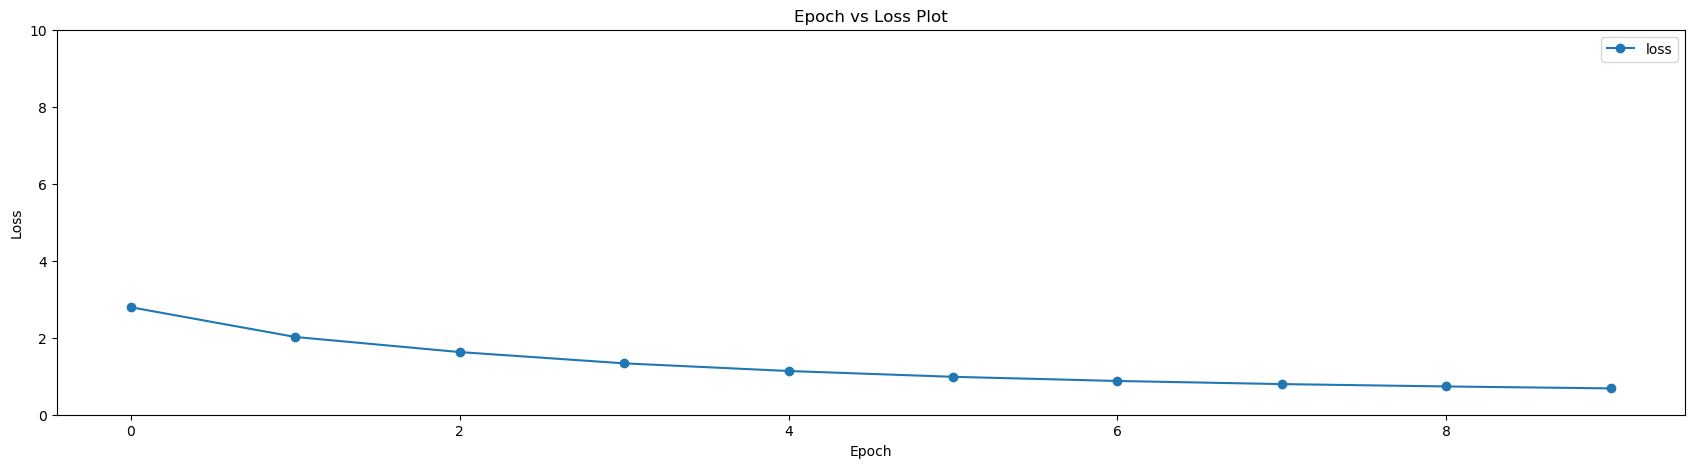

In [207]:
# train
train(
    model=user_isbn_text_deepconn,
    optimizer=opt,
    data_loader=user_isbn_text_train_dataloader,
    criterion=loss,
    device=device,
    epochs=10,
    model_name='user_isbn_text_deepconn_rmse',
)

In [208]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
user_isbn_text_deepconn = DeepCoNN(
                                    field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long), 
                                    embed_dim=128,
                                    word_dim=768, 
                                    out_dim=100, 
                                    kernel_size=3, 
                                    conv_1d_out_dim=50, 
                                    latent_dim=10,
                                    ).to(device)
opt = torch.optim.Adam(user_isbn_text_deepconn.parameters(), lr=1e-3)
loss = nn.MSELoss()

/tmp/ipykernel_57839/1796103825.py:3: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long),
/tmp/ipykernel_57839/1845160713.py:28: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use 

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 10/10 [06:13<00:00, 37.38s/it, loss=0.495]


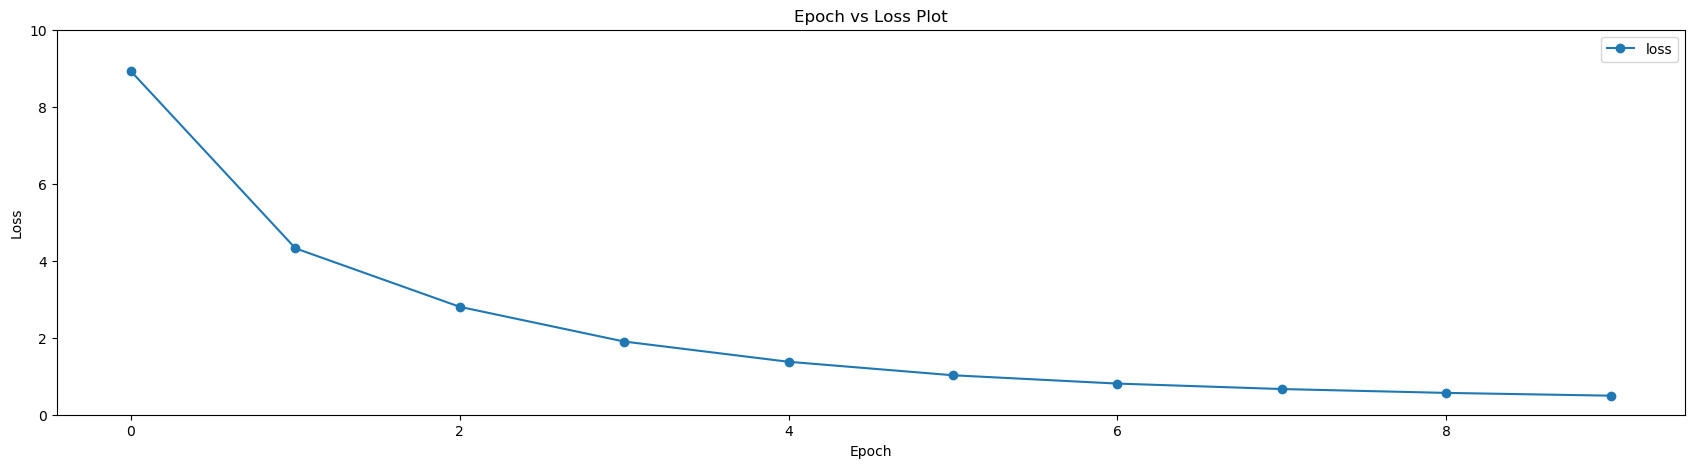

In [209]:
# train
train(
    model=user_isbn_text_deepconn,
    optimizer=opt,
    data_loader=user_isbn_text_train_dataloader,
    criterion=loss,
    device=device,
    epochs=10,
    model_name='user_isbn_text_deepconn_mse',
)

In [210]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
user_isbn_text_deepconn = DeepCoNN(
                                    field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long), 
                                    embed_dim=128,
                                    word_dim=768, 
                                    out_dim=100, 
                                    kernel_size=3, 
                                    conv_1d_out_dim=50, 
                                    latent_dim=10,
                                    ).to(device)
opt = torch.optim.Adam(user_isbn_text_deepconn.parameters(), lr=1e-3)
loss = nn.L1Loss()

/tmp/ipykernel_57839/3025055694.py:3: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  field_dims=np.array([len(user2idx), len(book2idx)], dtype=np.long),
/tmp/ipykernel_57839/1845160713.py:28: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use 

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 10/10 [06:14<00:00, 37.44s/it, loss=0.573]


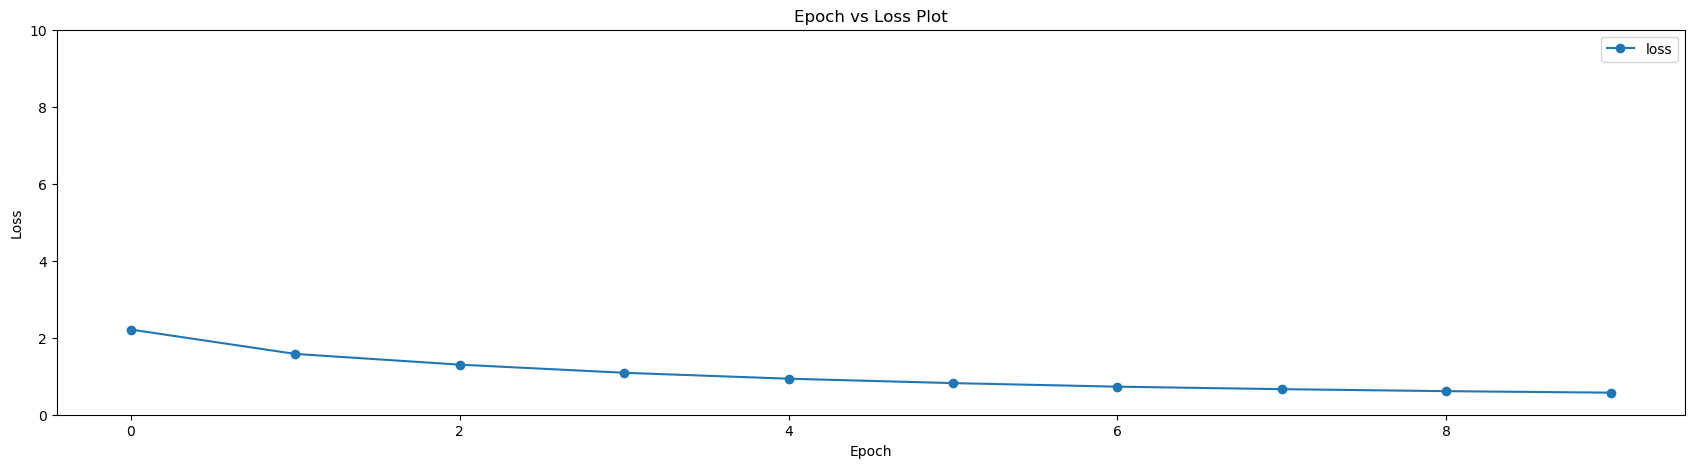

In [211]:
# train
train(
    model=user_isbn_text_deepconn,
    optimizer=opt,
    data_loader=user_isbn_text_train_dataloader,
    criterion=loss,
    device=device,
    epochs=10,
    model_name='user_isbn_text_deepconn_mae',
)

In [212]:
# User Isbn Text DeepCoNN model(mse) test
targets, predicts = test(
                        model=user_isbn_text_deepconn, 
                        data_loader=user_isbn_text_test_dataloader, 
                        device=device, 
                        model_name='user_isbn_text_deepconn_mse',
                        )

# score
user_isbn_text_deepconn_mse_score = pd.DataFrame([targets, predicts]).T
user_isbn_text_deepconn_mse_score.columns = ['actual_score', 'inference_score']
print("test score : {:.2f}".format(rmse_score(user_isbn_text_deepconn_mse_score['actual_score'].values , user_isbn_text_deepconn_mse_score['inference_score'].values)))
print(user_isbn_text_deepconn_mse_score.shape)
user_isbn_text_deepconn_mse_score.head()

  0%|          | 0/959 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 959/959 [00:04<00:00, 237.83it/s]


test score : 2.46
(61359, 2)


,actual_score,inference_score
0,7.0,6.200879
1,6.0,7.557038
2,8.0,7.984062
3,7.0,5.183307
4,9.0,6.249569


In [213]:
# User Isbn Text DeepCoNN model(mae) test
targets, predicts = test(
                        model=user_isbn_text_deepconn, 
                        data_loader=user_isbn_text_test_dataloader, 
                        device=device, 
                        model_name='user_isbn_text_deepconn_mae',
                        )

# score
user_isbn_text_deepconn_mae_score = pd.DataFrame([targets, predicts]).T
user_isbn_text_deepconn_mae_score.columns = ['actual_score', 'inference_score']
print("test score : {:.2f}".format(rmse_score(user_isbn_text_deepconn_mae_score['actual_score'].values , user_isbn_text_deepconn_mae_score['inference_score'].values)))
print(user_isbn_text_deepconn_mae_score.shape)
user_isbn_text_deepconn_mae_score.head()

  0%|          | 0/959 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 959/959 [00:04<00:00, 237.59it/s]


test score : 2.35
(61359, 2)


,actual_score,inference_score
0,7.0,7.119844
1,6.0,7.662937
2,8.0,8.332333
3,7.0,6.082517
4,9.0,9.511997


In [308]:
# User Isbn Text DeepCoNN model(rmse) test
targets, predicts = test(
                        model=user_isbn_text_deepconn, 
                        data_loader=user_isbn_text_test_dataloader, 
                        device=device, 
                        model_name='user_isbn_text_deepconn_rmse',
                        )

# score
user_isbn_text_deepconn_rmse_score = pd.DataFrame([targets, predicts]).T
user_isbn_text_deepconn_rmse_score.columns = ['actual_score', 'inference_score']

print("test score : {:.2f}".format(rmse_score(user_isbn_text_deepconn_rmse_score['actual_score'].values , user_isbn_text_deepconn_rmse_score['inference_score'].values)))
print(user_isbn_text_deepconn_rmse_score.shape)
user_isbn_text_deepconn_rmse_score.head()

  0%|          | 0/959 [00:00<?, ?it/s]/tmp/ipykernel_57839/1845160713.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'user_isbn_vector' : np.array(self.user_isbn_vector[i], dtype=np.long),
100%|██████████| 959/959 [00:04<00:00, 237.31it/s]


test score : 2.45
(61359, 2)


,actual_score,inference_score
0,7.0,6.175921
1,6.0,7.362338
2,8.0,8.081655
3,7.0,5.237461
4,9.0,8.614761


In [321]:
import math
user_isbn_text_deepconn_mae_score['error']=np.abs(user_isbn_text_deepconn_mae_score['actual_score']-user_isbn_text_deepconn_mae_score['inference_score'])
merge=pd.concat([user_isbn_text_deepconn_mae_score,X_test.reset_index()],axis=1)
mt3=merge[merge['error']>=2]
lt3=merge[merge['error']<2]

In [322]:
len(lt3), len(mt3)

(40967, 20392)

In [325]:
lt3['actual_score'].value_counts()

8.0     11994
7.0      9297
9.0      6813
10.0     4617
6.0      3969
5.0      1677
4.0      1230
3.0       688
2.0       507
1.0       175
Name: actual_score, dtype: int64

In [299]:
#df_fe_join.to_csv('summayembedding.csv',header=False)

In [311]:
print("test score : {:.2f}".format(rmse_score(user_isbn_text_deepconn_rmse_score['actual_score'].values , merge['inference_score'].values)))


test score : 2.35


0         7
1         8
2         8
3         6
4        10
         ..
61354     6
61355     6
61356     2
61357     9
61358     7
Name: inference_score, Length: 61359, dtype: int64